In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import warnings 
warnings.filterwarnings("ignore") 
import time 
import random
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process as gp 
from sklearn.gaussian_process.kernels import DotProduct as lin, WhiteKernel, RBF, ConstantKernel, RBF, WhiteKernel, RationalQuadratic, Exponentiation
import matplotlib.pyplot as plt

from torch._C import device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn

from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms


import tqdm

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
model = nn.Sequential(
    nn.Linear(15, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)

model = model.to(device) 

In [4]:
path, dirs, files = next(os.walk("drive/MyDrive/Auto/Data/Linear_error"))
file_count = len(files) 

Batch_size = 128
num_epochs = 100 #for each dataset 
optimizer = Adam(model.parameters(), lr=0.01)
mse_loss = nn.MSELoss() 


Loss = {}

def pd_to_torch(k):
  return torch.from_numpy(k.values).float().to(device) 

file_count_iter = tqdm.notebook.tqdm(range(file_count), desc="simulations") 

for i in file_count_iter:
  csv_file = f"drive/MyDrive/Auto/Data/Linear_error/linear_error_{i+1}.csv"  

  df = pd.read_csv(csv_file) 
  Drop = ['no_sim', 'time_step_H']
  
  for j in df.columns: #remove unnamed 
    if len(j) >=7 and j[:7] == 'Unnamed':
      df.drop(j, axis = 1, inplace = True) 

  for j in Drop:
    df.drop(j, axis = 1, inplace = True) #dropping no_sim and time_stamp_h
  
  ss = StandardScaler()

  X = torch.from_numpy(ss.fit_transform(df.iloc[:, :-2])).float().to(device) 
  Y = torch.from_numpy( df.iloc[:, -2:].to_numpy() ).float().to(device) 
  dataset = TensorDataset(X, Y)

  data_loader = DataLoader(dataset, batch_size=Batch_size, shuffle = False) 

  epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch") 
  Loss[i] = []

  for k in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(data_loader, desc="Minibatch", leave=False) 

    for x_batch, y_batch in minibatch_iter:
      output = model(x_batch)
      mse = mse_loss(output, y_batch)

      Loss[i].append(mse.item())


      optimizer.zero_grad()
      mse.backward()
      optimizer.step()

      minibatch_iter.set_postfix(mse=mse.item())
      

In [16]:
torch.save(model.state_dict(), 'drive/MyDrive/Auto/ANN/ANN.pth')

## TEST

In [22]:
test_csv_file_name = f"drive/MyDrive/Auto/Data/Linear_Test/Test_data_1.csv"
test_csv = pd.read_csv(test_csv_file_name)

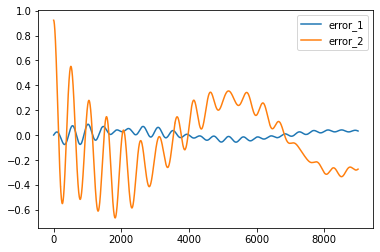

In [25]:
test_df = test_csv.iloc[:, 1:]

plt.plot(test_df['error_1'], label='error_1')
plt.plot(test_df['error_2'], label='error_2')
plt.legend()

In [44]:
ss = StandardScaler()
test_batch_size = 1024
test_X = torch.from_numpy(ss.fit_transform(test_df.iloc[:, :-2])).float().to(device) 
test_Y = torch.from_numpy( test_df.iloc[:, -2:].to_numpy() ).float().to(device) 
test_dataset = TensorDataset(test_X, test_Y)

test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle = False) 



In [45]:
model.eval()
i = 0
pred_error_1 = []
pred_error_2 = []
for x,y in test_data_loader:
  y_pred = model(x)
  pred_error_1.append( y_pred[:, 0].detach().cpu().numpy() )
  pred_error_2.append( y_pred[:, 1].detach().cpu().numpy() )

Pred_error_1 = list(np.concatenate(pred_error_1).flat) 
Pred_error_2 = list(np.concatenate(pred_error_2).flat) 

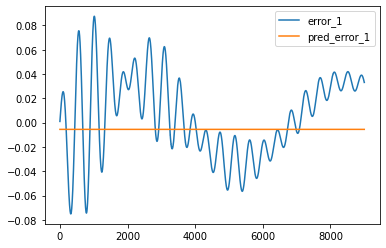

In [46]:
plt.plot(test_df['error_1'], label='error_1')
plt.plot(Pred_error_1, label='pred_error_1')

plt.legend()

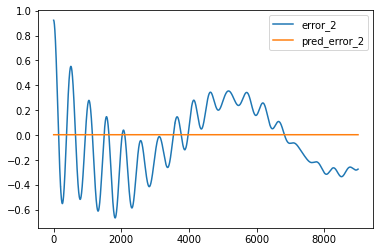

In [47]:
plt.plot(test_df['error_2'], label='error_2')
plt.plot(Pred_error_2, label='pred_error_2')

plt.legend()